In [1]:
# Cell 1: Colab and Kaggle setup
# 1) Upload your kaggle.json (from https://www.kaggle.com/<username>/account)
#    In Colab: Files pane -> Upload -> select kaggle.json
from google.colab import files
print("Please upload kaggle.json from your Kaggle account page.")
uploaded = files.upload()  # select kaggle.json

import os, json, zipfile, shutil
os.makedirs("/root/.kaggle", exist_ok=True)
with open("kaggle.json", "r") as f:
    token = json.load(f)

# Save credentials
with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(token, f)
os.chmod("/root/.kaggle/kaggle.json", 0o600)

# Install Kaggle API
!pip -q install kaggle
!kaggle --version


Please upload kaggle.json from your Kaggle account page.


Saving kaggle.json to kaggle.json
Kaggle API 1.7.4.5


In [2]:
# Cell 2: Download PlantVillage dataset
# Common dataset: "plantvillage-dataset" (e.g., crowdAI or variations). If this fails, search in Kaggle Datasets tab.
# Example: https://www.kaggle.com/datasets/emmarex/plantdisease
# Replace the dataset slug below if you prefer another PlantVillage mirror.

DATASET_SLUG = "emmarex/plantdisease"  # PlantVillage-like dataset; includes 'PlantVillage' images
DATA_DIR = "/content/data"
ARCHIVE_DIR = "/content/archive"

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(ARCHIVE_DIR, exist_ok=True)

!kaggle datasets download -d {DATASET_SLUG} -p {ARCHIVE_DIR} --force

# Unzip the dataset
for fname in os.listdir(ARCHIVE_DIR):
    if fname.endswith(".zip"):
        with zipfile.ZipFile(os.path.join(ARCHIVE_DIR, fname), "r") as z:
            z.extractall(DATA_DIR)

print("Data directory contents:", os.listdir(DATA_DIR))


Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
100% 656M/658M [00:01<00:00, 293MB/s]
100% 658M/658M [00:01<00:00, 378MB/s]
Data directory contents: ['plantvillage', 'PlantVillage']


In [3]:
# Cell 3: Inspect and normalize directory structure
# We will identify the image root containing class-subfolders. Adjust logic based on dataset layout.
from pathlib import Path

root = Path(DATA_DIR)
# Try common subfolder names
candidates = [
    root / "PlantVillage"
]
img_root = None
for c in candidates:
    if c.exists() and any(p.is_dir() for p in c.iterdir()):
        class_dirs = [p for p in c.iterdir() if p.is_dir()]
        # Heuristic: need multiple class folders
        if len(class_dirs) >= 2:
            img_root = c
            break

if img_root is None:
    raise RuntimeError("Could not automatically locate a folder with class subdirectories. Please inspect DATA_DIR and set img_root manually.")

print("Using image root:", img_root)
print("Found classes:", [p.name for p in img_root.iterdir() if p.is_dir()])


Using image root: /content/data/PlantVillage
Found classes: ['Potato___Late_blight', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Early_blight', 'Pepper__bell___healthy', 'Tomato_Bacterial_spot', 'Potato___healthy', 'Tomato_Late_blight', 'Tomato_Septoria_leaf_spot', 'Tomato_healthy', 'Pepper__bell___Bacterial_spot', 'Tomato__Tomato_mosaic_virus', 'Potato___Early_blight', 'Tomato_Leaf_Mold']


In [4]:
# Cell 4: Optional — programmatic split into train/val/test
# If your dataset already has train/val/test folders, skip this and set USE_PROGRAMMATIC_SPLIT=False below.
import random
import numpy as np

USE_PROGRAMMATIC_SPLIT = True
VAL_SPLIT = 0.15
TEST_SPLIT = 0.10
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

split_root = Path("/content/split")
train_dir = split_root / "train"
val_dir = split_root / "val"
test_dir = split_root / "test"

def safe_copy_tree(src_dir, dst_dir):
    dst_dir.mkdir(parents=True, exist_ok=True)
    for p in src_dir.iterdir():
        if p.is_dir():
            (dst_dir / p.name).mkdir(exist_ok=True)

if USE_PROGRAMMATIC_SPLIT:
    # Collect files by class
    classes = [p for p in img_root.iterdir() if p.is_dir()]
    for cls in classes:
        images = [p for p in cls.rglob("*") if p.is_file() and p.suffix.lower() in [".jpg", ".jpeg", ".png"]]
        random.shuffle(images)
        n = len(images)
        n_val = int(n * VAL_SPLIT)
        n_test = int(n * TEST_SPLIT)
        n_train = n - n_val - n_test

        splits = {
            train_dir / cls.name: images[:n_train],
            val_dir / cls.name: images[n_train:n_train+n_val],
            test_dir / cls.name: images[n_train+n_val:],
        }
        for out_dir, files_ in splits.items():
            out_dir.mkdir(parents=True, exist_ok=True)
            for f in files_:
                # Avoid name collisions by including class name
                dest = out_dir / f.name
                # If collision, prefix with an index
                i = 1
                while dest.exists():
                    dest = out_dir / f"{i}_{f.name}"
                    i += 1
                shutil.copy2(f, dest)

print("Split dirs created:",
      train_dir.exists(), val_dir.exists(), test_dir.exists())


Split dirs created: True True True


In [5]:
# Cell 6: Imports and device
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models

import time, copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


Torch: 2.9.0+cu126
CUDA available: True


In [6]:
# Cell 7: Transforms and datasets
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2  # Colab default: 2 is safe

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

eval_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# Choose source dirs depending on split
if USE_PROGRAMMATIC_SPLIT:
    train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
    val_dataset   = datasets.ImageFolder(root=val_dir, transform=eval_transforms)
    test_dataset  = datasets.ImageFolder(root=test_dir, transform=eval_transforms)
else:
    # If the dataset already had train/val/test
    pre_split_root = img_root  # adjust if different
    train_dataset = datasets.ImageFolder(root=pre_split_root / "train", transform=train_transforms)
    val_dataset   = datasets.ImageFolder(root=pre_split_root / "val", transform=eval_transforms)
    test_dataset  = datasets.ImageFolder(root=pre_split_root / "test", transform=eval_transforms)

num_classes = len(train_dataset.classes)
class_to_idx = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

print("Classes:", train_dataset.classes)
print("Dataset sizes — Train:", len(train_dataset), "Val:", len(val_dataset), "Test:", len(test_dataset))


Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Dataset sizes — Train: 15491 Val: 3089 Test: 2058


In [7]:
# Cell 8: Build ResNet50 and optimizer
# Use pretrained weights; modify final FC layer to match num_classes
resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
in_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(in_features, num_classes)

# Option: freeze backbone for quick baseline
FREEZE_BACKBONE = False
if FREEZE_BACKBONE:
    for name, p in resnet50.named_parameters():
        if not name.startswith("fc"):
            p.requires_grad = False

resnet50 = resnet50.to(device)

criterion = nn.CrossEntropyLoss()
LR = 3e-4
WEIGHT_DECAY = 1e-4
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, resnet50.parameters()),
                        lr=LR, weight_decay=WEIGHT_DECAY)
EPOCHS = 15
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)

scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s]
/tmp/ipython-input-1501401890.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


In [8]:
# Cell 9: Training and validation loops
def train_one_epoch(model, loader, optimizer, criterion, scaler):
    model.train()
    running_loss, running_corrects, total = 0.0, 0, 0

    for inputs, labels in loader:
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        preds = outputs.argmax(dim=1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += (preds == labels).sum().item()
        total += inputs.size(0)

    return running_loss / total, running_corrects / total

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, running_corrects, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    for inputs, labels in loader:
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        preds = outputs.argmax(dim=1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += (preds == labels).sum().item()
        total += inputs.size(0)

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

    return running_loss / total, running_corrects / total, torch.cat(all_preds).numpy(), torch.cat(all_labels).numpy()


In [9]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


CUDA available: True
Current device: cuda
GPU name: Tesla T4


In [10]:
# Cell 10: Run training

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
best_acc = 0.0
best_wts = copy.deepcopy(resnet50.state_dict())

start = time.time()
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(resnet50, train_loader, optimizer, criterion, scaler)
    val_loss, val_acc, _, _ = evaluate(resnet50, val_loader, criterion)
    scheduler.step()

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
        best_wts = copy.deepcopy(resnet50.state_dict())

    print(f"Epoch {epoch+1:02d}/{EPOCHS} | Train {train_acc:.4f} loss {train_loss:.4f} | Val {val_acc:.4f} loss {val_loss:.4f}")

elapsed = (time.time() - start) / 60
print(f"Training complete in {elapsed:.1f} min. Best Val Acc: {best_acc:.4f}")

resnet50.load_state_dict(best_wts)


/tmp/ipython-input-1515505138.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):


Epoch 01/15 | Train 0.8565 loss 0.4581 | Val 0.9712 loss 0.0964
Epoch 02/15 | Train 0.9549 loss 0.1353 | Val 0.9770 loss 0.0684
Epoch 03/15 | Train 0.9666 loss 0.1044 | Val 0.9880 loss 0.0477
Epoch 04/15 | Train 0.9765 loss 0.0720 | Val 0.9705 loss 0.0917
Epoch 05/15 | Train 0.9818 loss 0.0564 | Val 0.9858 loss 0.0569
Epoch 06/15 | Train 0.9841 loss 0.0500 | Val 0.9909 loss 0.0333
Epoch 07/15 | Train 0.9871 loss 0.0384 | Val 0.9916 loss 0.0291
Epoch 08/15 | Train 0.9912 loss 0.0261 | Val 0.9958 loss 0.0205
Epoch 09/15 | Train 0.9941 loss 0.0192 | Val 0.9958 loss 0.0191
Epoch 10/15 | Train 0.9962 loss 0.0119 | Val 0.9958 loss 0.0219
Epoch 11/15 | Train 0.9961 loss 0.0131 | Val 0.9961 loss 0.0149
Epoch 12/15 | Train 0.9979 loss 0.0076 | Val 0.9958 loss 0.0159
Epoch 13/15 | Train 0.9990 loss 0.0043 | Val 0.9971 loss 0.0137
Epoch 14/15 | Train 0.9987 loss 0.0043 | Val 0.9964 loss 0.0144
Epoch 15/15 | Train 0.9987 loss 0.0047 | Val 0.9971 loss 0.0144
Training complete in 19.6 min. Best Val 

<All keys matched successfully>

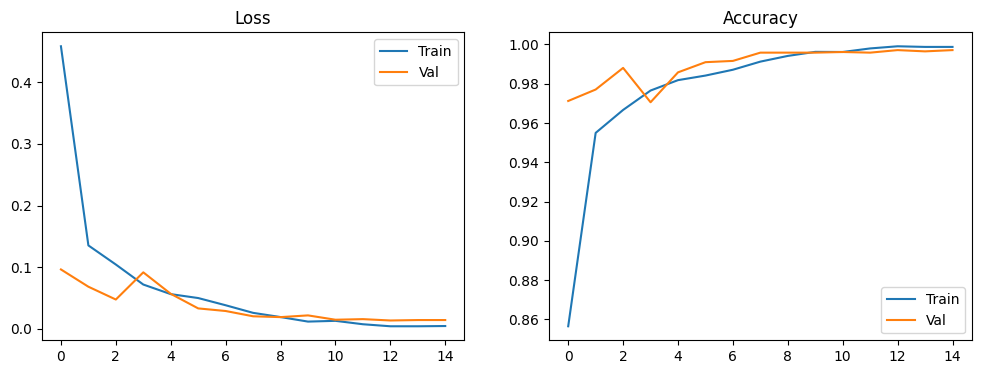

In [11]:
# Cell 11: Plot curves
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(history["train_loss"], label="Train")
axs[0].plot(history["val_loss"], label="Val")
axs[0].set_title("Loss")
axs[0].legend()

axs[1].plot(history["train_acc"], label="Train")
axs[1].plot(history["val_acc"], label="Val")
axs[1].set_title("Accuracy")
axs[1].legend()

plt.show()


Test Loss: 0.0033 | Test Acc: 0.9990
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      1.00      1.00        99
                     Pepper__bell___healthy       1.00      1.00      1.00       147
                      Potato___Early_blight       1.00      1.00      1.00       100
                       Potato___Late_blight       1.00      1.00      1.00       100
                           Potato___healthy       1.00      1.00      1.00        15
                      Tomato_Bacterial_spot       1.00      1.00      1.00       212
                        Tomato_Early_blight       1.00      1.00      1.00       100
                         Tomato_Late_blight       1.00      1.00      1.00       190
                           Tomato_Leaf_Mold       1.00      1.00      1.00        95
                  Tomato_Septoria_leaf_spot       1.00      1.00      1.00       177
Tomato_Spider_mites_Two_spo

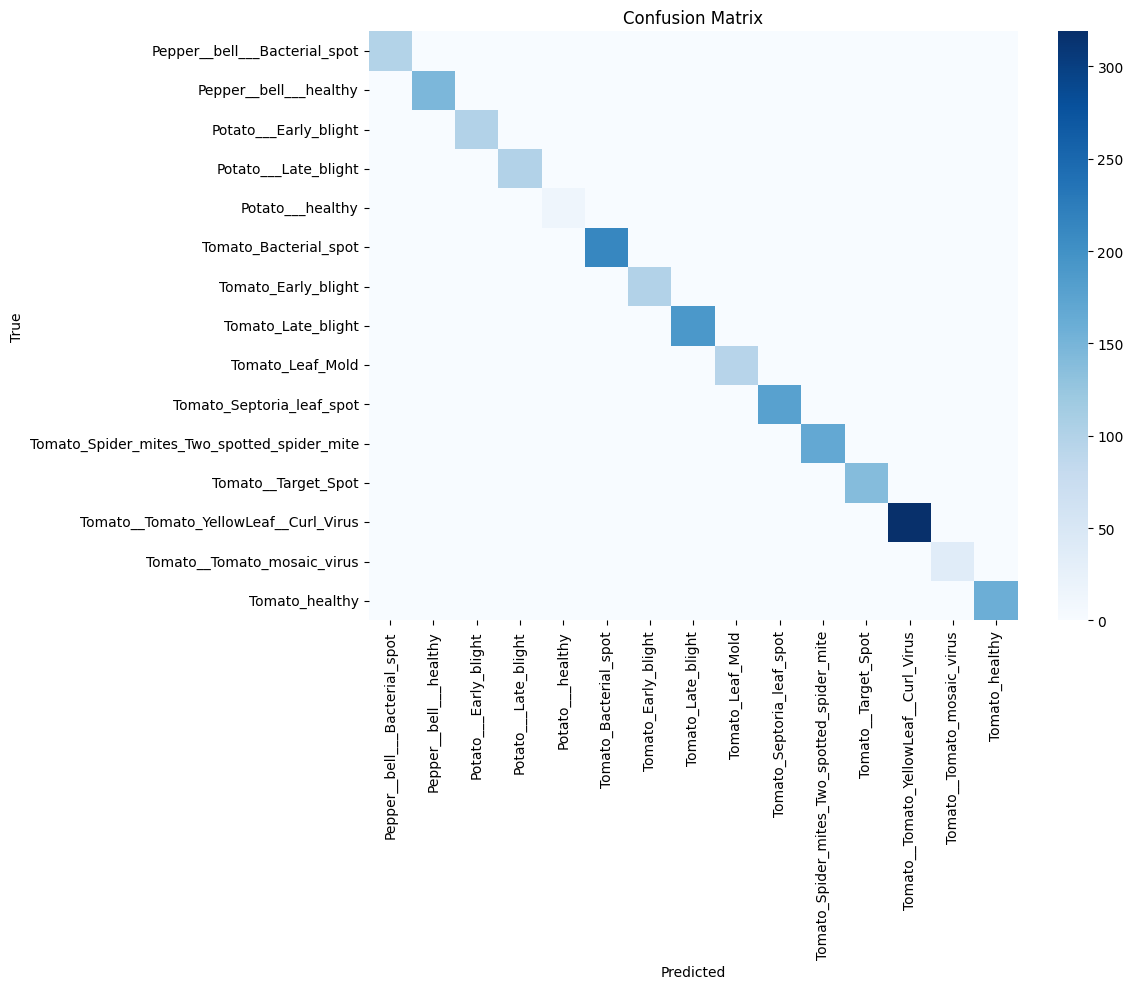

In [12]:
# Cell 12: Test set evaluation
test_loss, test_acc, test_preds, test_labels = evaluate(resnet50, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

target_names = [idx_to_class[i] for i in range(len(idx_to_class))]
print(classification_report(test_labels, test_preds, target_names=target_names))

cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [13]:
import torch
from pathlib import Path

SAVE_DIR = Path("/content/artifacts")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

MODEL_PATH = SAVE_DIR / "resnet50_plantvillage_checkpoint.pth"

checkpoint = {
    "model_state_dict": resnet50.state_dict(),
    "class_to_idx": class_to_idx,
    "idx_to_class": {v: k for k, v in class_to_idx.items()},
    "arch": "resnet50"
}

torch.save(checkpoint, MODEL_PATH)

print("Saved full checkpoint to:", MODEL_PATH)


Saved full checkpoint to: /content/artifacts/resnet50_plantvillage_checkpoint.pth
